# About

- 시계열로 밀어붙이기에는 label 에 비해 상대적으로 너무 데이터가 적어서 학습하기가 힘들것 같다.
- 불균형 데이터의 Classification 으로 무언가 조치가 필요해 보인다.
- Upsampling 보다는 다양한 모델을 앙상블하는게 좋을듯
- 아... 무언가 획기적인 방법이 필요하다. 

1. 한 개의 행은 0.02초 (second)를 의미합니다. 즉 하나의 id 에 대해서 600개의 time 이 존재하므로  총 12초(0.02*600)동안의 동작을 측정한 것입니다.

2. 이 때에 가속계와, 자이로스코프는 오른쪽 forearm(전완) 에 착용하여 측정한 데이터입니다.

3. 가속도계는 해당 방향으로의 가속도(g)를, 자이로스코프는 해당 방향으로의 dps(degrees per second)를 측정한 것입니다.


- 우선 가속도 방향은 항상 중력방향으로 작용한다. 그러므로 운동을 하지 않을 때에도 어느정도는 계속 측정이 되고있는 상태이다.
- 그렇다면 가속도의 합을 
- 가속도를 이용해서 각 각도 등을 측정 가능할 것이다. 

- x 축 방향(-)은 손바닥 방향으로 추정된다.
- 플랭크 시에 0 이였던 점 , push up 떄에 -1 인점 을 보아 맞는듯 하다.
- 그리고 acc 의 범위는 9.8 N = 1 으로 추정된다.(Push up 때에 -1 -> 즉 지구 중력은 9.8)
- 같은 운동에 대해 x 축은 비슷한 분포를 보이는 반면 y,x 축은 약간 역전된 느낌이다.
- 이는 즉 측정 기구를 찰때 전완근에 차기 때문에 y,z 의 측정은 불안정해 보인다.
- 그러므로! x 만 하는게 좋아보인다.?

- Moving average 를 통해서 그 추이를 알아내는게 매우 큰 도움이 된다.
- min max 의 차이를 얻어내는게 큰 도움이 된다.

- 갑자기 올라가는 지점인 첨도가 높은 지점의 정보를 추가해야될듯

- 이동평균과, 원래 값을 빼서, noise 를 측정하자!

# Setting

In [1]:
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from platform import python_version

# 모델 형성시 필요한 모듈
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.layers import Dense, Dropout, Activation,BatchNormalization,GRU, LSTM
import warnings
from scipy.signal import find_peaks

np.random.seed(42)
random.seed(42)

pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

train=pd.read_csv('./data/train_features.csv')
train_labels=pd.read_csv('./data/train_labels.csv')
test=pd.read_csv('./data/test_features.csv')
submission=pd.read_csv('./data/sample_submission.csv')

In [2]:
def whole_table(ex,train_labels):
    df_ex = pd.DataFrame()
    for exer in train_labels['label_desc'].sort_values().unique() :
        val = np.mean(ex.iloc[train_labels[train_labels['label_desc'] == exer]['id'],:],axis=0)
        df_ex = pd.concat([df_ex,pd.DataFrame(val,columns=[exer])],axis=1)
    return df_ex

In [3]:
def each_table(ex,train_labels,exer):
    each = ex.iloc[train_labels[train_labels['label_desc'] == exer]['id'],:].T
    return each

In [4]:
train_labels

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise
...,...,...,...
3120,3120,26,Non-Exercise
3121,3121,26,Non-Exercise
3122,3122,15,Dynamic Stretch (at your own pace)
3123,3123,26,Non-Exercise


In [5]:
#test'id'는 782개 
test['id'].nunique()

782

In [6]:
train_labels['label_desc'].unique()

array(['Shoulder Press (dumbbell)', 'Non-Exercise', 'Biceps Curl (band)',
       'Side Plank Right side', 'Plank', 'Chest Press (rack)',
       'Wall Squat', 'Russian Twist', 'Running (treadmill)',
       'Pushup (knee or foot variation)', 'Wall Ball',
       'Dynamic Stretch (at your own pace)',
       'Sit-up (hands positioned behind head)', 'Tap Right Device',
       'Static Stretch (at your own pace)', 'Device on Table',
       'Triceps extension (lying down)', 'Elliptical machine', 'Burpee',
       'Walking lunge', 'Lateral Raise', 'Jump Rope',
       'Triceps Kickback (knee on bench) (label spans both arms)',
       'Medicine Ball Slam',
       'Lunge (alternating both legs, weight optional)',
       'Fast Alternating Punches', 'Static stretch',
       'Squat Rack Shoulder Press', 'Overhead Triceps Extension',
       'Seated Back Fly', 'Bicep Curl', 'Side Plank Left side',
       'Dumbbell Squat (hands at side)', 'Dumbbell Deadlift Row',
       'Two-arm Dumbbell Curl (both arms, 

In [7]:
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478


In [8]:
#782개의 id 별 동작 데이터를 활용해 각각의id가 어떤 동작인지를 분류하는 문제!!
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3126,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3129,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
778,3903,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
779,3904,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
780,3905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# **데이터 살펴보기**

In [9]:
#train_labels.csv 에서 id 가 수행한 동작과 그에 따른 label값을 확인
# 아 이거 너~ 무 불균형인데?
# Validation 이... 지금 그냥 다 0.5
train_labels['label_desc'].value_counts()

Non-Exercise                                                1518
Device on Table                                               97
Plank                                                         55
Wall Squat                                                    48
Jump Rope                                                     47
Two-arm Dumbbell Curl (both arms, not alternating)            37
Tap Right Device                                              37
Dip                                                           37
V-up                                                          36
Pushup (knee or foot variation)                               35
Burpee                                                        35
Lunge (alternating both legs, weight optional)                35
Squat (arms in front of body, parallel to ground)             35
Shoulder Press (dumbbell)                                     35
Sit-up (hands positioned behind head)                         34
Overhead Triceps Extensio

In [10]:
#id 별로 각각 600개의 데이터가 있음을 확인   
train['id'].value_counts()

2047    600
1347    600
2378    600
1354    600
2379    600
       ... 
1699    600
675     600
2722    600
1698    600
0       600
Name: id, Length: 3125, dtype: int64

- 데이터가 1422 개 이므로, 무조건 15개 내외로 변수를 짜야한다.
- 괜히 너무 col이 많아도 과적합됨.
- 어짜피 tree 모델인데.. 

- 어짜피 너무 불균형한 운동은 없다. 한쪽이 크면 음수쪽도 큼. 그러므로 max 면 충분할것
- 중요한건 acc 이다. 이게 중력의 영향때문에

- noise
    - 차이값이 중요 (이는 30 이동평균한 값을 이용해, 이와의 차이값을 이용하면 될듯)
    - 차이를 알게된다면 심하게 진동하는 값에 대한 measure 로 작용 가능
- diff
    - 최대와 최소의 차이가 중요
    - 어느정도 심하게 변하고 있는지에 대한 measure  가능
- change_x
    - 평균과 차이의 절댓값 합
    - 평균으로부터 얼마나 떨어지는가의 예시가됨.
- local maxima(30) 
    - 30 이동평균시에 로컬 maximum
    - acc, gy 2개의 값이 생긴다.
- mean
    - 각 값의 min 은 매우 중요하다
    - 모든 운동은 '대칭적' 으로 이루어진다는 점에서 그 mean 을 통해서 손목 기계의 위치가 달라질것
    - 다만 gy 의 mean 은 거의다 0이다. 즉 추가함의 의미가 없어보인다.
    
- quantile(0.8) 보다 큰 값에 대해, 이어지는 행렬의 갯수가 50개 이 


In [11]:
def plot(exercise,df,lis1,lis2) : # 각 운동(exersice) 에 대해서 df set 에 대해 lis1, lis2 에 해당하는 그래프를 그려준다.
    plt.figure(figsize= (25,20))
    plt.subplots_adjust(top = 3)
    for i in range(0,5) :
        plt.subplot(12,2,2*i+1)
        idx = random.choice(list(train_labels[train_labels['label_desc'] == exercise ]['id']))
        plt.plot(df[df['id']==idx].loc[:,lis1])
        plt.legend(lis1)
        plt.title(exercise)
        plt.subplot(12,2,2*i+2)
        plt.plot(df[df['id']==idx].loc[:,lis2])
        plt.legend(lis2)
        plt.title(exercise)

In [12]:
#for i in train_labels['label_desc'].unique() :
#    plot(i,train,['acc_x','acc_y','acc_z'],['gy_x','gy_y','gy_z'])

# EDA

## Noise

- 원래 데이터 - 31 이동평균 데이터 를 뺀 이후에 abs 를 한 이후게 얻은 값
- 이 때에 각 quanile 0.9,0.1 을 normalizing 하여서 그 높낮이 값에 대한 Noise 변화의 증감을 낮췄다.
- 즉 이 값은 순수한 Noise의 크기 합을 나타낸다.

In [13]:
def moving(train):
    df_train = train.copy()
    df_train['index']= df_train.index
    df_train1 = train.loc[:,['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z']].groupby(train['id']).rolling(3,center=True).mean().reset_index().drop(columns=['level_1']).dropna().reset_index()
    df_train2 = train.loc[:,['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z']].groupby(train['id']).rolling(31,center=True).mean().reset_index().drop(columns=['level_1']).dropna().reset_index()
    df_new = pd.merge(df_train, df_train2, on='index')
    df_new.drop(columns=['id_y','time','index'],inplace = True)
    def quant(x):
        val1 = np.quantile(x,0.9)
        val2 = np.quantile(x,0.1)
        return(val1-val2)
    df_noise= df_new[['acc_x_x', 'acc_y_x', 'acc_z_x', 'gy_x_x', 'gy_y_x', 'gy_z_x']].values - df_new[['acc_x_y', 'acc_y_y', 'acc_z_y', 'gy_x_y', 'gy_y_y', 'gy_z_y']].values
    normalize = df_new.groupby('id_x').agg(quant)[['acc_x_x', 'acc_y_x', 'acc_z_x', 'gy_x_x', 'gy_y_x', 'gy_z_x']].values
    df_noise = pd.DataFrame(df_noise,columns=['noise_acc_x', 'noise_acc_y', 'noise_acc_z', 'noise_gy_x', 'noise_gy_y', 'noise_gy_z'])
    df_noise = pd.concat([df_new['id_x'],df_noise],axis=1)
    df_noise = np.abs(df_noise)
    df_noise = df_noise.groupby('id_x').agg(sum)
    df_noise = df_noise/ normalize
    df = df_noise
    df.reset_index(inplace = True,drop= True)
    return df, df_train, df_train1, df_train2

In [14]:
df,df_train,df_train1,df_train2 = moving(train)

## Local maximum

- train_2 (center 을 True 로 한 이동평균) 데 애해서, local maximum 의 수를 센다.
- 노이즈가 매우 많은 경우 큰 값을 나타나게 된다.

In [15]:
def Local(df,train):    
    def pick(x) :
        val = len(find_peaks(x)[0])
        return val
    ex = train.groupby('id').agg(pick) # id 를 기준으로 한다.
    df_local = ex.iloc[:,1:].reset_index(drop=True)
    df_local.columns = ['local_acc_x', 'local_acc_y', 'local_acc_z', 'local_gy_x', 'local_gy_y', 'local_gy_z']
    df = pd.concat([df,df_local],axis=1)
    return df

In [16]:
df = Local(df,df_train2)
df

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0


## Diff

- 3 이동평균을 제안한 값에 대하여, 최대값과 최소값의 차이를 조사한다.
- 그럴 경우 큰 차이가 난다면, 가동범위가 매우 크다는것을 의미한다.

In [17]:
def Diff(df, train):
    df_diff = train.groupby('id').max().iloc[:,1:] - train.groupby('id').min().iloc[:,1:]
    df_diff = df_diff.reset_index().iloc[:,1:]
    df_diff.columns = ['dif_acc_x', 'dif_acc_y', 'dif_acc_z', 'dif_gy_x', 'dif_gy_y', 'dif_gy_z']
    df = pd.concat([df,df_diff],axis=1)
    return(df)

In [18]:
df = Diff(df,train)

In [19]:
df

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0,0.752327,0.800985,0.731459,77.898959,155.734921,135.883856
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0,3.390228,1.995663,1.908192,611.952894,704.704062,611.151022
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0,2.362683,1.341634,1.259146,238.304149,547.274778,99.834907
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0,0.795502,0.824548,0.855938,262.184534,241.621092,142.057444
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0,3.028829,3.779858,3.928517,1383.049118,528.862903,491.597106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0,2.015509,1.457327,1.401151,342.522216,325.403639,201.350719
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0,1.128804,0.727708,0.621822,275.598931,87.099150,97.127504
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0,3.323641,3.304784,1.263216,1131.692422,769.568840,701.852483
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0,1.844979,1.201321,1.029780,376.923418,468.155225,517.139145


## Mean

- mean 은 3 평균을 취한 train1 에서부터 진행하자

In [20]:
def Mean(df,train) :
    df_mean = train.groupby('id').mean().reset_index().iloc[:,2:5]
    df_mean.columns = ['mean_acc_x', 'mean_acc_y', 'mean_acc_z']
    df = pd.concat([df,df_mean],axis=1)
    return(df)

In [21]:
df = Mean(df,df_train1)

In [22]:
df

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0,0.752327,0.800985,0.731459,77.898959,155.734921,135.883856,0.930537,-0.218199,-0.370759
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0,3.390228,1.995663,1.908192,611.952894,704.704062,611.151022,-0.768685,-0.317827,-0.007082
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0,2.362683,1.341634,1.259146,238.304149,547.274778,99.834907,0.039977,-0.081698,0.625277
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0,0.795502,0.824548,0.855938,262.184534,241.621092,142.057444,-0.887508,-0.086825,0.228431
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0,3.028829,3.779858,3.928517,1383.049118,528.862903,491.597106,-0.659146,-0.335625,0.204839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0,2.015509,1.457327,1.401151,342.522216,325.403639,201.350719,-0.301425,-0.668834,0.335230
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0,1.128804,0.727708,0.621822,275.598931,87.099150,97.127504,-0.974954,-0.233618,-0.073695
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0,3.323641,3.304784,1.263216,1131.692422,769.568840,701.852483,-1.112687,-0.361795,0.241552
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0,1.844979,1.201321,1.029780,376.923418,468.155225,517.139145,-0.109792,0.881698,-0.121676


## Dif_Mean

- Dif_Mean 은 평균을 취한 값과 그 차이를 계산한다

In [23]:
def Dif_Mean(df,train):
    df_temp = train.groupby('id').transform(np.mean).iloc[:,1:]
    df_mean = train[['acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z']] - df_temp
    df_mean.columns = ['mean_acc_x', 'mean_acc_y', 'mean_acc_z', 'mean_gy_x', 'mean_gy_y', 'mean_gy_z']
    df_temp = pd.concat([train[['id']],df_mean],axis=1)
    df_temp = np.abs(df_temp)
    df_mean = df_temp.groupby('id').sum()
    df_mean = df_mean.reset_index(drop=True)
    df_mean.columns =['dif_mean_acc_x', 'dif_mean_acc_y', 'dif_mean_acc_z', 'dif_mean_gy_x', 'dif_mean_gy_y','dif_mean_gy_z']
    df = pd.concat([df,df_mean],axis=1)
    return(df)

In [24]:
df = Dif_Mean(df,train)

In [25]:
df

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0,0.752327,0.800985,0.731459,77.898959,155.734921,135.883856,0.930537,-0.218199,-0.370759,101.261080,90.954770,64.906806,6291.724161,10823.913742,11495.699649
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0,3.390228,1.995663,1.908192,611.952894,704.704062,611.151022,-0.768685,-0.317827,-0.007082,236.474874,173.616985,242.339712,34040.164214,36792.649195,29955.121340
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0,2.362683,1.341634,1.259146,238.304149,547.274778,99.834907,0.039977,-0.081698,0.625277,390.114332,60.831949,130.344600,10487.938791,60791.968259,6278.553216
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0,0.795502,0.824548,0.855938,262.184534,241.621092,142.057444,-0.887508,-0.086825,0.228431,63.255069,97.259940,105.464514,19902.429768,15785.872506,10621.512125
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0,3.028829,3.779858,3.928517,1383.049118,528.862903,491.597106,-0.659146,-0.335625,0.204839,255.784854,298.550428,141.239503,28574.120301,19106.242883,14674.730822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0,2.015509,1.457327,1.401151,342.522216,325.403639,201.350719,-0.301425,-0.668834,0.335230,202.544544,83.180755,175.377956,12441.802512,13643.549698,8929.597544
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0,1.128804,0.727708,0.621822,275.598931,87.099150,97.127504,-0.974954,-0.233618,-0.073695,67.884086,53.465627,39.100570,15028.756983,6348.755853,4867.998495
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0,3.323641,3.304784,1.263216,1131.692422,769.568840,701.852483,-1.112687,-0.361795,0.241552,354.765341,158.624625,100.966108,70162.753230,131380.331908,69428.887346
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0,1.844979,1.201321,1.029780,376.923418,468.155225,517.139145,-0.109792,0.881698,-0.121676,213.976155,99.544730,135.297483,22168.228731,35476.116633,30306.922607


## Big

- Big 이란 Threshold 가 acc는1, 각도는100 이상의 갑작스런 변환이다.

In [26]:
def Big(df,train):
    def maxi_ac(x) :
        val = len(find_peaks(x,threshold=0.5)[0]) # 1
        return val
    def maxi_gy(x) :
        val = len(find_peaks(x,threshold=0.5)[0]) # 100
        return val
    ex = train.groupby('id').agg(maxi_ac)[['acc_x','acc_y','acc_z']]
    ex2 = train.groupby('id').agg(maxi_gy)[['gy_x','gy_y','gy_z']]
    df['big']= np.array(np.array(np.sum(ex,axis=1) + np.sum(ex2,axis=1)))
    return(df)

In [27]:
Big(df,train)

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z,big
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0,0.752327,0.800985,0.731459,77.898959,155.734921,135.883856,0.930537,-0.218199,-0.370759,101.261080,90.954770,64.906806,6291.724161,10823.913742,11495.699649,325.0
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0,3.390228,1.995663,1.908192,611.952894,704.704062,611.151022,-0.768685,-0.317827,-0.007082,236.474874,173.616985,242.339712,34040.164214,36792.649195,29955.121340,173.0
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0,2.362683,1.341634,1.259146,238.304149,547.274778,99.834907,0.039977,-0.081698,0.625277,390.114332,60.831949,130.344600,10487.938791,60791.968259,6278.553216,268.0
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0,0.795502,0.824548,0.855938,262.184534,241.621092,142.057444,-0.887508,-0.086825,0.228431,63.255069,97.259940,105.464514,19902.429768,15785.872506,10621.512125,173.0
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0,3.028829,3.779858,3.928517,1383.049118,528.862903,491.597106,-0.659146,-0.335625,0.204839,255.784854,298.550428,141.239503,28574.120301,19106.242883,14674.730822,146.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0,2.015509,1.457327,1.401151,342.522216,325.403639,201.350719,-0.301425,-0.668834,0.335230,202.544544,83.180755,175.377956,12441.802512,13643.549698,8929.597544,180.0
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0,1.128804,0.727708,0.621822,275.598931,87.099150,97.127504,-0.974954,-0.233618,-0.073695,67.884086,53.465627,39.100570,15028.756983,6348.755853,4867.998495,158.0
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0,3.323641,3.304784,1.263216,1131.692422,769.568840,701.852483,-1.112687,-0.361795,0.241552,354.765341,158.624625,100.966108,70162.753230,131380.331908,69428.887346,101.0
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0,1.844979,1.201321,1.029780,376.923418,468.155225,517.139145,-0.109792,0.881698,-0.121676,213.976155,99.544730,135.297483,22168.228731,35476.116633,30306.922607,173.0


## Q1, Q2, Q3

In [28]:
def q1q2q3(df,train):
    def quant_75(x):
        val = np.quantile(x, q=0.75)
        return val
    def quant_25(x):
        val = np.quantile(x, q=0.25)
        return val
    def quant_50(x):
        val = np.quantile(x, q=0.50)
        return val
    val1 = train.groupby('id').agg(quant_50).iloc[:,1:4].reset_index(drop=True)
    val2 = train.groupby('id').agg(quant_25).iloc[:,1:].reset_index(drop=True)
    val3 = train.groupby('id').agg(quant_75).iloc[:,1:].reset_index(drop=True)
    val1.columns = ['50x','50y','50z']
    val2.columns = ['25ax','25ay','25az','25gx','25gy','25gz']
    val3.columns = ['75ax','75ay','75az','75gx','75gy','75gz']
    df = pd.concat([df,val1,val2,val3],axis=1)
    return(df)

In [29]:
q1q2q3(df,train)

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z,big,50x,50y,50z,25ax,25ay,25az,25gx,25gy,25gz,75ax,75ay,75az,75gx,75gy,75gz
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0,0.752327,0.800985,0.731459,77.898959,155.734921,135.883856,0.930537,-0.218199,-0.370759,101.261080,90.954770,64.906806,6291.724161,10823.913742,11495.699649,325.0,0.956149,-0.240638,-0.346749,0.747302,-0.358621,-0.450826,-10.038454,-16.173177,-9.930266,1.080077,-0.067206,-0.272323,7.504551,9.931580,19.479614
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0,3.390228,1.995663,1.908192,611.952894,704.704062,611.151022,-0.768685,-0.317827,-0.007082,236.474874,173.616985,242.339712,34040.164214,36792.649195,29955.121340,173.0,-0.805767,-0.228905,-0.034583,-1.057583,-0.607455,-0.299597,-24.214776,-17.211791,-30.514605,-0.383457,-0.065757,0.436215,53.132366,40.053665,37.521852
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0,2.362683,1.341634,1.259146,238.304149,547.274778,99.834907,0.039977,-0.081698,0.625277,390.114332,60.831949,130.344600,10487.938791,60791.968259,6278.553216,268.0,0.140667,-0.062598,0.634781,-0.688672,-0.135405,0.399984,-18.906108,-114.664905,-4.718664,0.736468,-0.007626,0.827337,3.465504,93.063227,10.915188
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0,0.795502,0.824548,0.855938,262.184534,241.621092,142.057444,-0.887508,-0.086825,0.228431,63.255069,97.259940,105.464514,19902.429768,15785.872506,10621.512125,173.0,-0.880343,-0.054577,0.231537,-0.982072,-0.219341,0.057929,-11.660616,-16.350899,-19.096905,-0.784699,0.068742,0.449981,37.812543,20.463977,7.843401
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0,3.028829,3.779858,3.928517,1383.049118,528.862903,491.597106,-0.659146,-0.335625,0.204839,255.784854,298.550428,141.239503,28574.120301,19106.242883,14674.730822,146.0,-0.941146,-0.168467,0.293556,-0.960309,-0.899829,0.138963,-9.188574,-4.392364,-3.318290,-0.347234,0.090496,0.333143,7.597791,10.006328,12.739489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0,2.015509,1.457327,1.401151,342.522216,325.403639,201.350719,-0.301425,-0.668834,0.335230,202.544544,83.180755,175.377956,12441.802512,13643.549698,8929.597544,180.0,-0.105704,-0.737803,0.530820,-0.588712,-0.754197,0.124946,-8.464433,-3.977837,-5.959514,-0.086355,-0.590281,0.548821,3.315445,5.682352,2.601295
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0,1.128804,0.727708,0.621822,275.598931,87.099150,97.127504,-0.974954,-0.233618,-0.073695,67.884086,53.465627,39.100570,15028.756983,6348.755853,4867.998495,158.0,-0.980053,-0.208131,-0.084534,-1.021473,-0.297183,-0.117581,-5.818576,-1.393096,-6.335722,-0.909872,-0.169748,-0.022301,18.702096,9.545369,1.838386
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0,3.323641,3.304784,1.263216,1131.692422,769.568840,701.852483,-1.112687,-0.361795,0.241552,354.765341,158.624625,100.966108,70162.753230,131380.331908,69428.887346,101.0,-1.057063,-0.306436,0.242813,-1.697727,-0.601282,0.114727,-105.292055,-236.678297,-119.508096,-0.569290,-0.127102,0.378710,104.483424,251.016316,110.101101
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0,1.844979,1.201321,1.029780,376.923418,468.155225,517.139145,-

## Between

- -5~5 사이의 변동하지 않는 값의 길이를 조사한다.
- 이는 얼마나 휴식을 오래 취하고 있었는지를 조사한다

In [30]:
def bet(df,train):
    def bet(df) :
        val = np.sum(df.between(-0.5,0.5))
        return(val)
    bet = train.groupby('id').agg(bet)[['gy_x','gy_y','gy_z']].reset_index(drop=True)
    df[['bet_gy_x','bet_gy_y','bet_gy_z']] = bet
    return(df)

In [31]:
bet(df,train)

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z,big,bet_gy_x,bet_gy_y,bet_gy_z
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0,0.752327,0.800985,0.731459,77.898959,155.734921,135.883856,0.930537,-0.218199,-0.370759,101.261080,90.954770,64.906806,6291.724161,10823.913742,11495.699649,325.0,20.0,13.0,14.0
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0,3.390228,1.995663,1.908192,611.952894,704.704062,611.151022,-0.768685,-0.317827,-0.007082,236.474874,173.616985,242.339712,34040.164214,36792.649195,29955.121340,173.0,9.0,7.0,7.0
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0,2.362683,1.341634,1.259146,238.304149,547.274778,99.834907,0.039977,-0.081698,0.625277,390.114332,60.831949,130.344600,10487.938791,60791.968259,6278.553216,268.0,17.0,2.0,16.0
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0,0.795502,0.824548,0.855938,262.184534,241.621092,142.057444,-0.887508,-0.086825,0.228431,63.255069,97.259940,105.464514,19902.429768,15785.872506,10621.512125,173.0,9.0,11.0,13.0
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0,3.028829,3.779858,3.928517,1383.049118,528.862903,491.597106,-0.659146,-0.335625,0.204839,255.784854,298.550428,141.239503,28574.120301,19106.242883,14674.730822,146.0,23.0,72.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0,2.015509,1.457327,1.401151,342.522216,325.403639,201.350719,-0.301425,-0.668834,0.335230,202.544544,83.180755,175.377956,12441.802512,13643.549698,8929.597544,180.0,35.0,31.0,24.0
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0,1.128804,0.727708,0.621822,275.598931,87.099150,97.127504,-0.974954,-0.233618,-0.073695,67.884086,53.465627,39.100570,15028.756983,6348.755853,4867.998495,158.0,21.0,50.0,40.0
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0,3.323641,3.304784,1.263216,1131.692422,769.568840,701.852483,-1.112687,-0.361795,0.241552,354.765341,158.624625,100.966108,70162.753230,131380.331908,69428.887346,101.0,2.0,2.0,1.0
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0,1.844979,1.201321,1.029780,376.923418,468.155225,517.139145,-0.109792,0.881698,-0.121676,213.976155,99.544730,135.297483,22168.228731,35476.116633,30306.922607,173.0,7.0,2.0,5.0


# See data

In [32]:
whole_table(df,train_labels)

,Arm Band Adjustment,Band Pull-Down Row,Bicep Curl,Biceps Curl (band),Burpee,Butterfly Sit-up,Chest Press (rack),Crunch,Device on Table,Dip,Dumbbell Deadlift Row,Dumbbell Row (knee on bench) (label spans both arms),Dumbbell Row (knee on bench) (left arm),Dumbbell Row (knee on bench) (right arm),Dumbbell Squat (hands at side),Dynamic Stretch (at your own pace),Elliptical machine,Fast Alternating Punches,Jump Rope,Jumping Jacks,Kettlebell Swing,Lateral Raise,Lawnmower (left arm),Lawnmower (right arm),"Lunge (alternating both legs, weight optional)",Medicine Ball Slam,Non-Exercise,Overhead Triceps Extension,Plank,Power Boat pose,Pushup (knee or foot variation),Pushups,Repetitive Stretching,Rowing machine,Running (treadmill),Russian Twist,Seated Back Fly,Shoulder Press (dumbbell),Side Plank Left side,Side Plank Right side,Sit-up (hands positioned behind head),Sit-ups,Squat,"Squat (arms in front of body, parallel to ground)",Squat (hands behind head),Squat (kettlebell / goblet),Squat Jump,Squat Rack Shoulder Press,Static Stretch (at your own pace),Static stretch,Tap Right Device,Triceps Kickback (knee on bench) (label spans both arms),Triceps Kickback (knee on bench) (left arm),Triceps Kickback (knee on bench) (right arm),Triceps extension (lying down),"Two-arm Dumbbell Curl (both arms, not alternating)",V-up,Walk,Walking lunge,Wall Ball,Wall Squat
noise_acc_x,77.747111,121.341207,36.138691,51.831901,134.104368,64.991041,107.433514,72.720181,169.251277,164.728040,95.474264,120.349251,174.523268,79.414052,93.513203,123.669805,105.684495,176.559359,183.240936,140.507112,52.929491,40.744540,136.139474,49.292324,106.460668,108.251668,79.075843,48.744194,154.379102,121.471465,165.103845,165.761130,105.958936,72.485080,153.035165,81.357449,55.171650,102.698383,140.187330,170.362037,56.490145,82.171877,89.118946,96.779420,78.283599,76.761471,136.397982,121.093743,108.426352,70.963799,62.934656,117.080252,185.854206,73.428098,32.780705,31.605651,76.224387,145.821435,117.239375,179.504655,140.127598
noise_acc_y,90.267535,141.424747,98.553771,126.491289,164.946062,53.422648,127.630727,84.053974,169.246182,135.010092,121.697206,139.159969,150.819209,135.639047,135.099767,125.431788,179.031313,192.535026,186.680997,138.969353,81.771999,90.976411,96.470478,83.297832,119.263843,127.803265,80.160695,59.225918,141.066078,161.264140,152.294671,161.077713,90.003872,156.214451,166.840062,117.771614,90.677284,105.320726,120.312295,159.624964,63.916101,93.988398,77.060873,81.351637,68.777925,88.268366,132.146097,70.679543,82.050845,79.195159,86.505304,108.555871,142.943077,68.802246,55.316575,86.962196,52.525018,123.242582,126.546700,140.368160,131.291789
noise_acc_z,56.052516,111.825688,73.861184,89.439125,160.486296,68.232071,114.115128,64.038860,159.745057,126.042118,102.690569,128.014548,152.435897,124.606135,101.132305,105.115400,165.342750,189.209009,180.759348,167.205220,75.658930,74.222779,91.212265,96.669503,113.056679,134.152422,66.097853,45.546533,144.568324,114.258280,133.152515,143.361532,89.362587,129.153943,147.809053,78.696908,70.081014,113.152820,121.775377,161.883393,83.108364,81.955549,94.129654,87.227510,80.423183,76.308774,147.749517,79.263833,75.565885,61.804060,64.432721,102.235923,139.821891,73.630897,63.739644,72.628430,82.349201,133.946267,123.600439,122.004436,114.793242
noise_gy_x,136.450770,129.305824,129.231138,145.575730,165.660237,95.552900,148.385539,59.590340,815.189257,161.163227,136.280821,138.085953,151.161670,135.768321,111.482514,123.396629,155.970957,166.105669,181.119955,164.771166,81.084547,100.208128,60.870812,110.518983,141.551724,150.561632,117.871778,126.250374,207.213366,179.511306,157.005796,158.078767,143.100804,140.302171,160.804150,119.292968,120.578053,113.203678,168.603427,193.755968,78.493000,122.293709,135.295965,131.623244,59.343667,112.269662,149.256199,104.820831,144.671944,143.351539,135.849863,151.362072,173.940286,119.472950,114.871617,121.185496,108.215464,131.725010,148.801757,120.295090,19

In [33]:
each_table(df,train_labels,'Tap Right Device')

,33,116,140,180,248,260,326,525,674,791,817,898,901,935,1021,1136,1138,1164,1250,1307,1370,1611,1686,1837,1876,1946,1966,2226,2274,2455,2510,2544,2564,2693,2830,2984,3050
noise_acc_x,58.500282,64.110054,51.117380,47.731448,69.902249,40.928134,40.844527,73.228144,35.835857,71.089125,40.370034,76.383554,101.642380,41.174507,61.866967,46.766215,41.256427,126.832054,47.973907,86.970699,34.555217,66.572186,107.625073,34.274217,80.851430,73.583406,38.971512,36.708090,59.803293,59.592345,57.755159,31.832073,92.581839,99.717829,74.942789,61.008335,93.683530
noise_acc_y,194.526842,89.962048,93.430727,47.059086,80.386125,52.705506,48.843225,106.492449,69.807269,94.398301,68.336813,72.630057,104.686278,53.006179,69.457814,54.897775,85.205109,153.591095,48.718983,90.924956,69.628230,98.696403,94.776997,61.949248,113.151720,89.850453,68.956317,91.230351,58.774545,66.589791,59.780341,42.832404,137.465792,144.441231,86.345308,111.469971,125.690500
noise_acc_z,123.391244,53.360897,88.048292,38.722034,76.657945,52.818438,43.856260,60.009898,40.288459,31.062876,32.298270,50.836555,48.766090,34.839028,44.359450,120.043905,36.243591,106.418320,54.673066,48.503140,135.018604,73.394215,94.898274,66.853768,77.824677,77.199120,61.002293,42.784750,68.138822,66.643839,60.734101,36.733214,75.604424,106.585102,49.518854,57.126945,48.751937
noise_gy_x,135.523085,135.302935,175.452092,127.436746,148.043733,202.035957,88.852770,59.470116,131.963063,104.178919,86.101372,143.566129,174.132106,126.468344,157.239800,226.494908,90.017197,149.311630,149.127678,126.701815,123.120747,114.927578,153.464394,122.636863,115.634458,170.616744,114.571690,133.658782,158.785482,132.009191,140.921551,112.660011,136.107246,144.120345,198.130110,84.235402,133.423961
noise_gy_y,158.134315,126.860975,113.839857,110.198843,122.349470,71.497770,111.407161,104.868570,105.311873,96.987622,88.832651,156.186821,167.540148,80.229176,141.292632,196.670764,64.296226,166.851949,94.748015,150.992619,133.274154,121.506836,177.479424,112.562951,179.896448,147.760391,113.400763,116.481093,179.974950,122.124835,81.120554,107.005524,131.856933,124.286024,106.986726,98.076399,91.909516
noise_gy_z,158.885268,124.164880,151.866522,99.358965,125.316306,92.554609,61.718031,79.584324,103.028409,68.987966,106.396338,115.849013,143.764699,124.841575,126.003851,192.928846,93.730052,96.741226,102.385234,157.166565,127.389777,153.606811,172.277503,96.500755,131.363561,123.578012,56.009883,86.089305,119.002259,89.947668,82.150525,56.404809,157.519376,99.624904,98.499189,112.559073,119.656534
local_acc_x,34.000000,47.000000,42.000000,33.000000,54.000000,40.000000,35.000000,37.000000,37.000000,29.000000,26.000000,49.000000,44.000000,34.000000,39.000000,52.000000,20.000000,33.000000,41.000000,41.000000,37.000000,55.000000,46.000000,24.000000,29.000000,42.000000,31.000000,36.000000,51.000000,38.000000,23.000000,44.000000,40.000000,32.000000,25.000000,31.000000,47.000000
local_acc_y,43.000000,57.000000,43.000000,55.000000,49.000000,35.000000,39.000000,42.000000,30.000000,38.000000,31.000000,41.000000,46.000000,49.000000,38.000000,38.000000,31.000000,55.000000,55.000000,40.000000,41.000000,64.000000,46.000000,29.000000,42.000000,42.000000,48.000000,40.000000,37.000000,46.000000,21.000000,54.000000,45.000000,55.000000,32.000000,25.000000,53.000000
local_acc_z,37.000000,48.000000,43.000000,42.000000,43.000000,24.000000,27.000000,31.000000,32.000000,16.000000,20.000000,39.000000,54.000000,33.000000,45.000000,54.000000,19.000000,32.000000,31.000000,40.000000,26.000000,44.000000,46.000000,26.000000,36.000000,26.000000,36.000000,31.000000,32.000000,27.000000,18.000000,40.000000,29.000000,36.000000,21.000000,22.000000,35.000000
local_gy_x,35.000000,47.000000,40.000000,34.000000,50.000000,34.000000,36.000000,27.000000,29.000000,22.000000,26.000000,38.000000,42.000000,33.000000,36.000000,40.000000,30.000000,40.000000,35.000000,37.000000,22.000000,45.000000,37.000000,24.000000,32.000000,39.000000,39.000000,24.000000,39.0

In [34]:
y = train_labels['label'].copy()
X = df.copy()

In [35]:
df.columns

Index(['noise_acc_x', 'noise_acc_y', 'noise_acc_z', 'noise_gy_x', 'noise_gy_y',
       'noise_gy_z', 'local_acc_x', 'local_acc_y', 'local_acc_z', 'local_gy_x',
       'local_gy_y', 'local_gy_z', 'dif_acc_x', 'dif_acc_y', 'dif_acc_z',
       'dif_gy_x', 'dif_gy_y', 'dif_gy_z', 'mean_acc_x', 'mean_acc_y',
       'mean_acc_z', 'dif_mean_acc_x', 'dif_mean_acc_y', 'dif_mean_acc_z',
       'dif_mean_gy_x', 'dif_mean_gy_y', 'dif_mean_gy_z', 'big', 'bet_gy_x',
       'bet_gy_y', 'bet_gy_z'],
      dtype='object')

# EDA2

## Scaling

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [37]:
scaler.fit(X)

StandardScaler()

In [38]:
X = scaler.transform(X)

## Split

In [39]:
from sklearn.model_selection import train_test_split
X_train,X_val, y_train, y_val = train_test_split(X,y, test_size=0.20, random_state=0,stratify=y)

## Upsampling

In [40]:
#from imblearn.combine import *

In [41]:
#temp = train_labels['label'].value_counts() * 4
#dic = dict(zip(temp.index,temp.values))

In [42]:
#dic[26] = 1400

In [43]:
#from imblearn.over_sampling import ADASYN
#from imblearn.over_sampling import RandomOverSampler

In [44]:
#X_samp, y_samp = ADASYN(random_state=0,sampling_strategy=dic).fit_sample(X_train, y_train)

In [45]:
#X_train = X_samp
#y_train = y_samp

## Weight 생성

In [46]:
temp = train_labels['label'].value_counts()

In [47]:
# 이대로 하게 되면, 너무 weight 가 과대추정되어서 좋지않다.
# 3배만 주도록 하자. 
temp[1:] = temp[1:] * 4

In [48]:
di= np.array(temp.sort_index())


# **모델링**

In [49]:
df

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z,big,bet_gy_x,bet_gy_y,bet_gy_z
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0,0.752327,0.800985,0.731459,77.898959,155.734921,135.883856,0.930537,-0.218199,-0.370759,101.261080,90.954770,64.906806,6291.724161,10823.913742,11495.699649,325.0,20.0,13.0,14.0
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0,3.390228,1.995663,1.908192,611.952894,704.704062,611.151022,-0.768685,-0.317827,-0.007082,236.474874,173.616985,242.339712,34040.164214,36792.649195,29955.121340,173.0,9.0,7.0,7.0
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0,2.362683,1.341634,1.259146,238.304149,547.274778,99.834907,0.039977,-0.081698,0.625277,390.114332,60.831949,130.344600,10487.938791,60791.968259,6278.553216,268.0,17.0,2.0,16.0
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0,0.795502,0.824548,0.855938,262.184534,241.621092,142.057444,-0.887508,-0.086825,0.228431,63.255069,97.259940,105.464514,19902.429768,15785.872506,10621.512125,173.0,9.0,11.0,13.0
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0,3.028829,3.779858,3.928517,1383.049118,528.862903,491.597106,-0.659146,-0.335625,0.204839,255.784854,298.550428,141.239503,28574.120301,19106.242883,14674.730822,146.0,23.0,72.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0,2.015509,1.457327,1.401151,342.522216,325.403639,201.350719,-0.301425,-0.668834,0.335230,202.544544,83.180755,175.377956,12441.802512,13643.549698,8929.597544,180.0,35.0,31.0,24.0
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0,1.128804,0.727708,0.621822,275.598931,87.099150,97.127504,-0.974954,-0.233618,-0.073695,67.884086,53.465627,39.100570,15028.756983,6348.755853,4867.998495,158.0,21.0,50.0,40.0
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0,3.323641,3.304784,1.263216,1131.692422,769.568840,701.852483,-1.112687,-0.361795,0.241552,354.765341,158.624625,100.966108,70162.753230,131380.331908,69428.887346,101.0,2.0,2.0,1.0
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0,1.844979,1.201321,1.029780,376.923418,468.155225,517.139145,-0.109792,0.881698,-0.121676,213.976155,99.544730,135.297483,22168.228731,35476.116633,30306.922607,173.0,7.0,2.0,5.0


## Neural Network

In [308]:
tf.random.set_seed(42)

# 모델 훈련
model1 = keras.models.Sequential()
model1 = Sequential([
    Dropout(0.1,input_shape=X_train.shape[1:]),
    Dense(128, kernel_initializer='he_normal', activation = "elu"),
    Dropout(0.4),
    Dense(128, kernel_initializer='he_normal', activation = "elu"),
    Dropout(0.4),
    Dense(61, activation = 'softmax')])

model1.compile(loss="sparse_categorical_crossentropy",  # 평가기준이 mape 이니까 이걸로 하자.
              optimizer=keras.optimizers.Adam())

early_stopping = keras.callbacks.EarlyStopping(patience=16,
                                               monitor = 'val_loss',
                                             restore_best_weights=True)

history1 = model1.fit(X_train, y_train,
                      callbacks = [early_stopping],
                      class_weight=di,
                      batch_size = 10,
                    epochs=1000,
                        validation_data=(X_val, y_val))

Train on 2500 samples, validate on 625 samples
Epoch 1/1000
2500/2500 [==============================] - 1s 321us/sample - loss: 3.1390 - val_loss: 1.6001
Epoch 2/1000
2500/2500 [==============================] - 0s 154us/sample - loss: 1.9428 - val_loss: 1.2692
Epoch 3/1000
2500/2500 [==============================] - 0s 143us/sample - loss: 1.7085 - val_loss: 1.1100
Epoch 4/1000
2500/2500 [==============================] - 0s 118us/sample - loss: 1.4995 - val_loss: 0.9955
Epoch 5/1000
2500/2500 [==============================] - 0s 110us/sample - loss: 1.3714 - val_loss: 0.9609
Epoch 6/1000
2500/2500 [==============================] - 0s 115us/sample - loss: 1.2679 - val_loss: 0.8931
Epoch 7/1000
2500/2500 [==============================] - 0s 150us/sample - loss: 1.1978 - val_loss: 0.8537
Epoch 8/1000
2500/2500 [==============================] - 0s 143us/sample - loss: 1.1507 - val_loss: 0.8345
Epoch 9/1000
2500/2500 [==============================] - 0s 126us/sample - loss: 1.1156 

KeyboardInterrupt: 

In [134]:
# 모델 훈련
model2 = keras.models.Sequential()
model2 = Sequential([
    Dropout(0.3,input_shape=X_train.shape[1:]),
    Dense(128, activation = "relu"),
    Dropout(0.4),
    Dense(61, activation = 'softmax')])

model2.compile(loss="sparse_categorical_crossentropy",  # 평가기준이 mape 이니까 이걸로 하자.
              optimizer=keras.optimizers.Adam())

early_stopping = keras.callbacks.EarlyStopping(patience=64,
                                               monitor = 'val_loss',
                                             restore_best_weights=True)

history2 = model2.fit(X_train, y_train,
                      callbacks = [early_stopping],
                      batch_size = 10,
                        epochs=1000,
                        validation_data=(X_val, y_val))

Train on 2500 samples, validate on 625 samples
Epoch 1/1000
2500/2500 [==============================] - 1s 265us/sample - loss: 2.8572 - val_loss: 1.9799
Epoch 2/1000
2500/2500 [==============================] - 0s 114us/sample - loss: 1.9649 - val_loss: 1.5468
Epoch 3/1000
2500/2500 [==============================] - 0s 93us/sample - loss: 1.7269 - val_loss: 1.3288
Epoch 4/1000
2500/2500 [==============================] - 0s 138us/sample - loss: 1.5694 - val_loss: 1.1893
Epoch 5/1000
2500/2500 [==============================] - 0s 127us/sample - loss: 1.4567 - val_loss: 1.1019
Epoch 6/1000
2500/2500 [==============================] - 0s 99us/sample - loss: 1.3624 - val_loss: 1.0335
Epoch 7/1000
2500/2500 [==============================] - 0s 108us/sample - loss: 1.3303 - val_loss: 1.0028
Epoch 8/1000
2500/2500 [==============================] - 0s 120us/sample - loss: 1.3226 - val_loss: 0.9676
Epoch 9/1000
2500/2500 [==============================] - 0s 113us/sample - loss: 1.2478 - 

In [220]:
model1.predict_classes(X_val)

array([42, 26, 27, 26,  2, 26, 26, 58, 26, 26, 26,  4, 20, 26, 59, 26,  8,
       26, 39, 26, 36, 26, 46,  8, 26, 26, 26, 29, 23, 26, 55, 55, 47, 26,
       12, 58, 37, 26, 55, 11,  5, 26, 26, 26,  9, 21, 26, 26, 13, 26, 26,
       26, 26, 26, 33, 26, 26, 26, 26, 16, 26, 31, 57, 26, 26, 25, 26, 26,
       26, 26, 15,  4, 26, 26, 26, 26, 26, 26, 26, 42, 26, 26, 54, 26, 59,
       12, 26, 26, 26,  8, 33, 26,  1, 53, 27, 26, 26,  9, 26, 26, 26, 26,
       40, 57, 26, 57, 30,  5, 26, 43, 24, 26, 26,  6, 40, 56,  3, 26,  7,
       26, 26, 19, 44, 26, 26, 45, 26, 26, 26,  2, 26, 58, 26, 51, 26,  9,
       26, 26, 23, 31, 26, 21,  6, 35, 35, 20, 26, 26, 26, 26, 26, 58, 55,
       26, 26, 28, 26, 26, 56, 26, 26, 26, 15, 26, 39, 38, 26, 58,  8, 26,
        8, 26, 26, 28, 26, 26, 26, 26, 25, 53, 40, 26, 17, 14, 26, 26, 56,
        8, 26, 26, 60, 26, 16, 31, 34, 26, 26, 43, 29, 38, 26, 25, 38, 26,
       26, 26, 26, 56, 26, 26, 26,  9,  9, 26, 26, 28, 17, 56, 26, 26, 26,
       26, 26, 26, 26, 26

In [221]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

q = pd.DataFrame(range(0,61),columns=['label'])
idx = np.array(pd.merge(q,train_labels[['label','label_desc']],on='label').drop_duplicates()['label_desc'])
class_name = idx
print( classification_report(y_val,model1.predict_classes(X_val),target_names= class_name ) )

                                                          precision    recall  f1-score   support

                                     Arm Band Adjustment       1.00      0.50      0.67         2
                                      Band Pull-Down Row       1.00      1.00      1.00         4
                                              Bicep Curl       0.17      0.25      0.20         4
                                      Biceps Curl (band)       0.50      0.40      0.44         5
                                                  Burpee       0.75      0.86      0.80         7
                                        Butterfly Sit-up       1.00      0.60      0.75         5
                                      Chest Press (rack)       0.57      0.80      0.67         5
                                                  Crunch       0.80      0.80      0.80         5
                                         Device on Table       1.00      1.00      1.00        20
                   

In [69]:
confusion= pd.DataFrame(confusion_matrix(y_val, model.predict(X_val)),columns = idx)

In [70]:
confusion.index = idx

In [71]:
confusion

,Arm Band Adjustment,Band Pull-Down Row,Bicep Curl,Biceps Curl (band),Burpee,Butterfly Sit-up,Chest Press (rack),Crunch,Device on Table,Dip,Dumbbell Deadlift Row,Dumbbell Row (knee on bench) (label spans both arms),Dumbbell Row (knee on bench) (left arm),Dumbbell Row (knee on bench) (right arm),Dumbbell Squat (hands at side),Dynamic Stretch (at your own pace),Elliptical machine,Fast Alternating Punches,Jump Rope,Jumping Jacks,Kettlebell Swing,Lateral Raise,Lawnmower (left arm),Lawnmower (right arm),"Lunge (alternating both legs, weight optional)",Medicine Ball Slam,Non-Exercise,Overhead Triceps Extension,Plank,Power Boat pose,Pushup (knee or foot variation),Pushups,Repetitive Stretching,Rowing machine,Running (treadmill),Russian Twist,Seated Back Fly,Shoulder Press (dumbbell),Side Plank Left side,Side Plank Right side,Sit-up (hands positioned behind head),Sit-ups,Squat,"Squat (arms in front of body, parallel to ground)",Squat (hands behind head),Squat (kettlebell / goblet),Squat Jump,Squat Rack Shoulder Press,Static Stretch (at your own pace),Static stretch,Tap Right Device,Triceps Kickback (knee on bench) (label spans both arms),Triceps Kickback (knee on bench) (left arm),Triceps Kickback (knee on bench) (right arm),Triceps extension (lying down),"Two-arm Dumbbell Curl (both arms, not alternating)",V-up,Walk,Walking lunge,Wall Ball,Wall Squat
Arm Band Adjustment,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Band Pull-Down Row,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bicep Curl,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Biceps Curl (band),0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Burpee,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Butterfly Sit-up,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Chest Press (rack),0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Crunch,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Device on Table,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Dip,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 제출

## 최종 Upsampling

In [50]:
#from imblearn.over_sampling import ADASYN
#from imblearn.over_sampling import RandomOverSampler
#X_samp, y_samp = ADASYN(random_state=0,sampling_strategy=dic).fit_sample(X, y)

## Test set 변환

In [51]:
df_,df_test,df_test1,df_test2 = moving(test)

In [52]:
df_ = Local(df_,df_test2)
df_

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z
0,103.443727,152.399926,110.633155,146.225813,105.267515,104.871208,29.0,71.0,14.0,76.0,10.0,19.0
1,36.452674,66.451195,31.310371,101.654960,76.669291,70.050272,13.0,24.0,19.0,19.0,16.0,12.0
2,178.598511,89.573358,73.162080,110.884419,134.943854,136.203925,50.0,41.0,32.0,32.0,37.0,23.0
3,20.125753,27.224241,17.309542,156.539291,92.334863,95.833209,17.0,23.0,21.0,24.0,10.0,10.0
4,107.638975,86.104446,74.982720,141.932183,115.434813,119.718000,35.0,38.0,28.0,32.0,22.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...
777,156.812649,146.388248,118.621095,162.534717,102.178606,110.881004,41.0,43.0,32.0,26.0,16.0,19.0
778,64.493962,91.453967,121.484417,104.481811,101.855842,88.917450,30.0,27.0,21.0,23.0,14.0,11.0
779,69.684258,52.444999,47.272767,104.314210,106.932561,102.342289,28.0,23.0,23.0,32.0,22.0,16.0
780,96.833254,115.526519,103.745360,99.141690,78.821067,120.031935,40.0,66.0,39.0,24.0,12.0,16.0


In [53]:
df_ = Diff(df_,df_test1)
df_

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z
0,103.443727,152.399926,110.633155,146.225813,105.267515,104.871208,29.0,71.0,14.0,76.0,10.0,19.0,1.238118,0.590079,0.709008,84.895278,171.149042,80.255480
1,36.452674,66.451195,31.310371,101.654960,76.669291,70.050272,13.0,24.0,19.0,19.0,16.0,12.0,2.172011,1.751576,1.555044,372.603348,311.911508,313.693212
2,178.598511,89.573358,73.162080,110.884419,134.943854,136.203925,50.0,41.0,32.0,32.0,37.0,23.0,2.822718,1.255271,0.883553,227.708767,151.695240,224.844549
3,20.125753,27.224241,17.309542,156.539291,92.334863,95.833209,17.0,23.0,21.0,24.0,10.0,10.0,1.348216,0.969437,1.169263,341.240853,283.540908,282.097175
4,107.638975,86.104446,74.982720,141.932183,115.434813,119.718000,35.0,38.0,28.0,32.0,22.0,27.0,1.629312,1.885360,1.519058,669.200145,438.325355,254.475745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,156.812649,146.388248,118.621095,162.534717,102.178606,110.881004,41.0,43.0,32.0,26.0,16.0,19.0,2.154180,3.426526,1.488343,1332.525922,415.079994,451.484385
778,64.493962,91.453967,121.484417,104.481811,101.855842,88.917450,30.0,27.0,21.0,23.0,14.0,11.0,3.084106,2.534085,1.570273,638.280804,414.250454,397.864937
779,69.684258,52.444999,47.272767,104.314210,106.932561,102.342289,28.0,23.0,23.0,32.0,22.0,16.0,1.475043,1.497980,1.193010,368.136655,253.820712,393.096662
780,96.833254,115.526519,103.745360,99.141690,78.821067,120.031935,40.0,66.0,39.0,24.0,12.0,16.0,0.716203,0.489123,0.703171,119.586779,174.070061,104.623559


In [54]:
df_ = Mean(df_,df_test1)
df_

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z
0,103.443727,152.399926,110.633155,146.225813,105.267515,104.871208,29.0,71.0,14.0,76.0,10.0,19.0,1.238118,0.590079,0.709008,84.895278,171.149042,80.255480,-1.019356,-0.019195,-0.233210
1,36.452674,66.451195,31.310371,101.654960,76.669291,70.050272,13.0,24.0,19.0,19.0,16.0,12.0,2.172011,1.751576,1.555044,372.603348,311.911508,313.693212,-0.523168,0.610759,-0.070763
2,178.598511,89.573358,73.162080,110.884419,134.943854,136.203925,50.0,41.0,32.0,32.0,37.0,23.0,2.822718,1.255271,0.883553,227.708767,151.695240,224.844549,0.506954,0.903966,-0.140994
3,20.125753,27.224241,17.309542,156.539291,92.334863,95.833209,17.0,23.0,21.0,24.0,10.0,10.0,1.348216,0.969437,1.169263,341.240853,283.540908,282.097175,-0.576289,-0.611267,0.032192
4,107.638975,86.104446,74.982720,141.932183,115.434813,119.718000,35.0,38.0,28.0,32.0,22.0,27.0,1.629312,1.885360,1.519058,669.200145,438.325355,254.475745,-0.739660,0.182189,0.400607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,156.812649,146.388248,118.621095,162.534717,102.178606,110.881004,41.0,43.0,32.0,26.0,16.0,19.0,2.154180,3.426526,1.488343,1332.525922,415.079994,451.484385,-0.909197,0.486886,-0.238174
778,64.493962,91.453967,121.484417,104.481811,101.855842,88.917450,30.0,27.0,21.0,23.0,14.0,11.0,3.084106,2.534085,1.570273,638.280804,414.250454,397.864937,-0.612035,0.370271,-0.108080
779,69.684258,52.444999,47.272767,104.314210,106.932561,102.342289,28.0,23.0,23.0,32.0,22.0,16.0,1.475043,1.497980,1.193010,368.136655,253.820712,393.096662,-0.752458,0.199790,0.312260
780,96.833254,115.526519,103.745360,99.141690,78.821067,120.031935,40.0,66.0,39.0,24.0,12.0,16.0,0.716203,0.489123,0.703171,119.586779,174.070061,104.623559,0.958915,-0.320980,-0.356390


In [55]:
df_ = Dif_Mean(df_,test)

In [56]:
df_

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z
0,103.443727,152.399926,110.633155,146.225813,105.267515,104.871208,29.0,71.0,14.0,76.0,10.0,19.0,1.238118,0.590079,0.709008,84.895278,171.149042,80.255480,-1.019356,-0.019195,-0.233210,113.142606,41.386256,88.823479,6046.788273,14737.667332,5482.327105
1,36.452674,66.451195,31.310371,101.654960,76.669291,70.050272,13.0,24.0,19.0,19.0,16.0,12.0,2.172011,1.751576,1.555044,372.603348,311.911508,313.693212,-0.523168,0.610759,-0.070763,261.461048,170.438811,193.943447,22237.065864,19665.103823,28645.786660
2,178.598511,89.573358,73.162080,110.884419,134.943854,136.203925,50.0,41.0,32.0,32.0,37.0,23.0,2.822718,1.255271,0.883553,227.708767,151.695240,224.844549,0.506954,0.903966,-0.140994,62.137478,95.347372,75.285231,9846.892109,5245.916651,9622.727946
3,20.125753,27.224241,17.309542,156.539291,92.334863,95.833209,17.0,23.0,21.0,24.0,10.0,10.0,1.348216,0.969437,1.169263,341.240853,283.540908,282.097175,-0.576289,-0.611267,0.032192,238.343292,116.581230,161.187822,13120.961915,15337.533189,12864.493877
4,107.638975,86.104446,74.982720,141.932183,115.434813,119.718000,35.0,38.0,28.0,32.0,22.0,27.0,1.629312,1.885360,1.519058,669.200145,438.325355,254.475745,-0.739660,0.182189,0.400607,136.852763,151.217840,130.793046,36507.132971,28744.872301,18966.648874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,156.812649,146.388248,118.621095,162.534717,102.178606,110.881004,41.0,43.0,32.0,26.0,16.0,19.0,2.154180,3.426526,1.488343,1332.525922,415.079994,451.484385,-0.909197,0.486886,-0.238174,133.976094,136.842298,92.716036,54293.615806,31259.778435,28319.951771
778,64.493962,91.453967,121.484417,104.481811,101.855842,88.917450,30.0,27.0,21.0,23.0,14.0,11.0,3.084106,2.534085,1.570273,638.280804,414.250454,397.864937,-0.612035,0.370271,-0.108080,299.704804,186.121960,109.384173,37256.934439,25434.719080,39222.971173
779,69.684258,52.444999,47.272767,104.314210,106.932561,102.342289,28.0,23.0,23.0,32.0,22.0,16.0,1.475043,1.497980,1.193010,368.136655,253.820712,393.096662,-0.752458,0.199790,0.312260,122.708753,156.263383,132.447290,16619.493762,14271.650146,18639.216142
780,96.833254,115.526519,103.745360,99.141690,78.821067,120.031935,40.0,66.0,39.0,24.0,12.0,16.0,0.716203,0.489123,0.703171,119.586779,174.070061,104.623559,0.958915,-0.320980,-0.356390,83.472363,56.760531,84.841468,15309.347190,21302.401369,13572.810095


In [57]:
Big(df_,test)

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z,big
0,103.443727,152.399926,110.633155,146.225813,105.267515,104.871208,29.0,71.0,14.0,76.0,10.0,19.0,1.238118,0.590079,0.709008,84.895278,171.149042,80.255480,-1.019356,-0.019195,-0.233210,113.142606,41.386256,88.823479,6046.788273,14737.667332,5482.327105,276.0
1,36.452674,66.451195,31.310371,101.654960,76.669291,70.050272,13.0,24.0,19.0,19.0,16.0,12.0,2.172011,1.751576,1.555044,372.603348,311.911508,313.693212,-0.523168,0.610759,-0.070763,261.461048,170.438811,193.943447,22237.065864,19665.103823,28645.786660,139.0
2,178.598511,89.573358,73.162080,110.884419,134.943854,136.203925,50.0,41.0,32.0,32.0,37.0,23.0,2.822718,1.255271,0.883553,227.708767,151.695240,224.844549,0.506954,0.903966,-0.140994,62.137478,95.347372,75.285231,9846.892109,5245.916651,9622.727946,240.0
3,20.125753,27.224241,17.309542,156.539291,92.334863,95.833209,17.0,23.0,21.0,24.0,10.0,10.0,1.348216,0.969437,1.169263,341.240853,283.540908,282.097175,-0.576289,-0.611267,0.032192,238.343292,116.581230,161.187822,13120.961915,15337.533189,12864.493877,58.0
4,107.638975,86.104446,74.982720,141.932183,115.434813,119.718000,35.0,38.0,28.0,32.0,22.0,27.0,1.629312,1.885360,1.519058,669.200145,438.325355,254.475745,-0.739660,0.182189,0.400607,136.852763,151.217840,130.793046,36507.132971,28744.872301,18966.648874,172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,156.812649,146.388248,118.621095,162.534717,102.178606,110.881004,41.0,43.0,32.0,26.0,16.0,19.0,2.154180,3.426526,1.488343,1332.525922,415.079994,451.484385,-0.909197,0.486886,-0.238174,133.976094,136.842298,92.716036,54293.615806,31259.778435,28319.951771,121.0
778,64.493962,91.453967,121.484417,104.481811,101.855842,88.917450,30.0,27.0,21.0,23.0,14.0,11.0,3.084106,2.534085,1.570273,638.280804,414.250454,397.864937,-0.612035,0.370271,-0.108080,299.704804,186.121960,109.384173,37256.934439,25434.719080,39222.971173,145.0
779,69.684258,52.444999,47.272767,104.314210,106.932561,102.342289,28.0,23.0,23.0,32.0,22.0,16.0,1.475043,1.497980,1.193010,368.136655,253.820712,393.096662,-0.752458,0.199790,0.312260,122.708753,156.263383,132.447290,16619.493762,14271.650146,18639.216142,137.0
780,96.833254,115.526519,103.745360,99.141690,78.821067,120.031935,40.0,66.0,39.0,24.0,12.0,16.0,0.716203,0.489123,0.703171,119.586779,174.070061,104.623559,0.958915,-0.320980,-0.356390,83.472363,56.760531,84.841468,15309.347190,21302.401369,13572.810095,283.0


In [58]:
q1q2q3(df_,test)

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z,big,50x,50y,50z,25ax,25ay,25az,25gx,25gy,25gz,75ax,75ay,75az,75gx,75gy,75gz
0,103.443727,152.399926,110.633155,146.225813,105.267515,104.871208,29.0,71.0,14.0,76.0,10.0,19.0,1.238118,0.590079,0.709008,84.895278,171.149042,80.255480,-1.019356,-0.019195,-0.233210,113.142606,41.386256,88.823479,6046.788273,14737.667332,5482.327105,276.0,-1.064222,-0.005735,-0.268442,-1.171423,-0.067276,-0.366774,-12.242792,-16.727839,-9.483683,-0.870436,0.038509,-0.096772,4.608388,21.918686,5.104833
1,36.452674,66.451195,31.310371,101.654960,76.669291,70.050272,13.0,24.0,19.0,19.0,16.0,12.0,2.172011,1.751576,1.555044,372.603348,311.911508,313.693212,-0.523168,0.610759,-0.070763,261.461048,170.438811,193.943447,22237.065864,19665.103823,28645.786660,139.0,-0.677411,0.606215,-0.026089,-0.920825,0.324459,-0.405850,-46.076338,-17.657753,-43.569149,-0.245532,0.869302,0.180556,14.285215,22.748130,29.512729
2,178.598511,89.573358,73.162080,110.884419,134.943854,136.203925,50.0,41.0,32.0,32.0,37.0,23.0,2.822718,1.255271,0.883553,227.708767,151.695240,224.844549,0.506954,0.903966,-0.140994,62.137478,95.347372,75.285231,9846.892109,5245.916651,9622.727946,240.0,0.497370,0.931239,-0.156647,0.444073,0.749816,-0.251624,-14.932788,-7.958948,-13.266111,0.555121,1.036079,-0.031064,11.130037,4.401338,12.942246
3,20.125753,27.224241,17.309542,156.539291,92.334863,95.833209,17.0,23.0,21.0,24.0,10.0,10.0,1.348216,0.969437,1.169263,341.240853,283.540908,282.097175,-0.576289,-0.611267,0.032192,238.343292,116.581230,161.187822,13120.961915,15337.533189,12864.493877,58.0,-0.880541,-0.507927,-0.092860,-0.918008,-0.745235,-0.121194,-5.502614,-11.395791,-9.005791,-0.105972,-0.455508,0.338411,9.030723,7.958351,8.768108
4,107.638975,86.104446,74.982720,141.932183,115.434813,119.718000,35.0,38.0,28.0,32.0,22.0,27.0,1.629312,1.885360,1.519058,669.200145,438.325355,254.475745,-0.739660,0.182189,0.400607,136.852763,151.217840,130.793046,36507.132971,28744.872301,18966.648874,172.0,-0.703842,0.122280,0.432678,-0.910040,-0.014741,0.199498,-39.209632,-30.657626,-12.864438,-0.591973,0.400696,0.592846,28.360521,35.399137,28.747350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,156.812649,146.388248,118.621095,162.534717,102.178606,110.881004,41.0,43.0,32.0,26.0,16.0,19.0,2.154180,3.426526,1.488343,1332.525922,415.079994,451.484385,-0.909197,0.486886,-0.238174,133.976094,136.842298,92.716036,54293.615806,31259.778435,28319.951771,121.0,-0.973938,0.445913,-0.196808,-1.073317,0.353606,-0.323781,-49.775165,-29.091108,-25.513229,-0.850689,0.596629,-0.099386,59.078936,37.944800,29.619127
778,64.493962,91.453967,121.484417,104.481811,101.855842,88.917450,30.0,27.0,21.0,23.0,14.0,11.0,3.084106,2.534085,1.570273,638.280804,414.250454,397.864937,-0.612035,0.370271,-0.108080,299.704804,186.121960,109.384173,37256.934439,25434.719080,39222.971173,145.0,-0.812788,0.333884,-0.094524,-1.032177,0.129319,-0.260794,-41.010312,-28.297405,-48.732587,-0.375927,0.629643,0.025133,40.395003,36.325370,66.403974
779,69.684258,52.444999,47.272767,104.314210,106.932561,102.342289,28.0,23.0,23.0,32.0,22.0,16.0,1.475043,1.497980,1.193010,368.136655,253.820712,393.096662,-0.752458,0.199790,0.312260,122.708753,156.263383,132.447290,16619.493762,14271.650146,18639.216142,137.0,-0.809029,0.097582,0.402556,-0.923777,-0.010090,0.097516,-9.608239,-14.756146,-20.144907,-0.509140,0.495247,0.522110,16.691601,15.423510,15.890101
780,96.833254,115.526519,103.745360,99.141690,78.821067,120.031935,40.0,66.0,39.0,24.0,12.0,16.0,0.716203,0.489123,0.703171,119.586779,174.070061,104.623559,

In [59]:
bet(df_,test)

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z,big,bet_gy_x,bet_gy_y,bet_gy_z
0,103.443727,152.399926,110.633155,146.225813,105.267515,104.871208,29.0,71.0,14.0,76.0,10.0,19.0,1.238118,0.590079,0.709008,84.895278,171.149042,80.255480,-1.019356,-0.019195,-0.233210,113.142606,41.386256,88.823479,6046.788273,14737.667332,5482.327105,276.0,18.0,13.0,28.0
1,36.452674,66.451195,31.310371,101.654960,76.669291,70.050272,13.0,24.0,19.0,19.0,16.0,12.0,2.172011,1.751576,1.555044,372.603348,311.911508,313.693212,-0.523168,0.610759,-0.070763,261.461048,170.438811,193.943447,22237.065864,19665.103823,28645.786660,139.0,7.0,10.0,5.0
2,178.598511,89.573358,73.162080,110.884419,134.943854,136.203925,50.0,41.0,32.0,32.0,37.0,23.0,2.822718,1.255271,0.883553,227.708767,151.695240,224.844549,0.506954,0.903966,-0.140994,62.137478,95.347372,75.285231,9846.892109,5245.916651,9622.727946,240.0,7.0,17.0,8.0
3,20.125753,27.224241,17.309542,156.539291,92.334863,95.833209,17.0,23.0,21.0,24.0,10.0,10.0,1.348216,0.969437,1.169263,341.240853,283.540908,282.097175,-0.576289,-0.611267,0.032192,238.343292,116.581230,161.187822,13120.961915,15337.533189,12864.493877,58.0,20.0,30.0,24.0
4,107.638975,86.104446,74.982720,141.932183,115.434813,119.718000,35.0,38.0,28.0,32.0,22.0,27.0,1.629312,1.885360,1.519058,669.200145,438.325355,254.475745,-0.739660,0.182189,0.400607,136.852763,151.217840,130.793046,36507.132971,28744.872301,18966.648874,172.0,4.0,8.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,156.812649,146.388248,118.621095,162.534717,102.178606,110.881004,41.0,43.0,32.0,26.0,16.0,19.0,2.154180,3.426526,1.488343,1332.525922,415.079994,451.484385,-0.909197,0.486886,-0.238174,133.976094,136.842298,92.716036,54293.615806,31259.778435,28319.951771,121.0,6.0,1.0,7.0
778,64.493962,91.453967,121.484417,104.481811,101.855842,88.917450,30.0,27.0,21.0,23.0,14.0,11.0,3.084106,2.534085,1.570273,638.280804,414.250454,397.864937,-0.612035,0.370271,-0.108080,299.704804,186.121960,109.384173,37256.934439,25434.719080,39222.971173,145.0,2.0,3.0,1.0
779,69.684258,52.444999,47.272767,104.314210,106.932561,102.342289,28.0,23.0,23.0,32.0,22.0,16.0,1.475043,1.497980,1.193010,368.136655,253.820712,393.096662,-0.752458,0.199790,0.312260,122.708753,156.263383,132.447290,16619.493762,14271.650146,18639.216142,137.0,21.0,16.0,26.0
780,96.833254,115.526519,103.745360,99.141690,78.821067,120.031935,40.0,66.0,39.0,24.0,12.0,16.0,0.716203,0.489123,0.703171,119.586779,174.070061,104.623559,0.958915,-0.320980,-0.356390,83.472363,56.760531,84.841468,15309.347190,21302.401369,13572.810095,283.0,6.0,5.0,5.0


## Scaling

In [60]:
df_ = scaler.transform(df_)

## 최종 FITTING (NN)

In [61]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)

In [62]:
def NN_model():
    model = Sequential([
        Dropout(0.1,input_shape=X_train.shape[1:]),
        Dense(128, kernel_initializer='he_normal', activation = "elu"),
        Dropout(0.4),
        Dense(128, kernel_initializer='he_normal', activation = "elu"),
        Dropout(0.4),
        Dense(61, activation = 'softmax')])
    model.compile(loss="sparse_categorical_crossentropy",  # 평가기준이 mape 이니까 이걸로 하자.
              optimizer=keras.optimizers.Adam())
    return model

Train on 2500 samples, validate on 625 samples
Epoch 1/1000
2500/2500 [==============================] - 1s 290us/sample - loss: 3.1985 - val_loss: 1.5847
Epoch 2/1000
2500/2500 [==============================] - 0s 127us/sample - loss: 1.9831 - val_loss: 1.2266
Epoch 3/1000
2500/2500 [==============================] - 0s 149us/sample - loss: 1.6543 - val_loss: 1.0888
Epoch 4/1000
2500/2500 [==============================] - 0s 163us/sample - loss: 1.4617 - val_loss: 1.0046
Epoch 5/1000
2500/2500 [==============================] - 0s 157us/sample - loss: 1.3821 - val_loss: 0.9421
Epoch 6/1000
2500/2500 [==============================] - 0s 164us/sample - loss: 1.2672 - val_loss: 0.8993
Epoch 7/1000
2500/2500 [==============================] - 0s 159us/sample - loss: 1.1633 - val_loss: 0.8583
Epoch 8/1000
2500/2500 [==============================] - 0s 135us/sample - loss: 1.1405 - val_loss: 0.8392
Epoch 9/1000
2500/2500 [==============================] - 0s 132us/sample - loss: 1.0939 

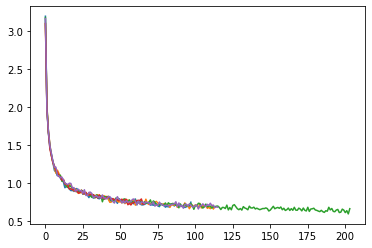

In [63]:
all_preds = []
idx = 0

for train_index, val_index in kf.split(X,y):
    tf.random.set_seed(42)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = NN_model()
    early_stopping = keras.callbacks.EarlyStopping(patience=32,
                                               monitor = 'val_loss',
                                             restore_best_weights=True)
    history = model.fit(X_train, y_train,
                          callbacks = [early_stopping],
                          class_weight=di,
                          batch_size = 10,
                          epochs=1000,
                          validation_data=(X_val, y_val))
    idx+=1
    plt.plot(history.history['loss'], label='train' + str(idx))
    
    pred = model.predict_proba(df_)
    all_preds.append(pred)    

In [64]:
prediction = np.mean(all_preds,axis=0)

In [65]:
prediction.shape

(782, 61)

In [66]:
submission.iloc[:,1:]=prediction

In [67]:
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,9.461437e-07,3.771536e-08,5.805558e-05,1.176697e-03,1.245442e-05,1.251267e-08,1.049413e-04,1.148678e-08,6.138506e-06,3.130284e-02,9.267213e-02,1.727919e-01,9.894883e-03,4.037524e-02,2.752168e-02,2.284688e-06,7.057715e-07,4.894233e-08,5.342819e-07,1.710731e-05,8.443638e-06,8.248065e-04,1.446034e-07,8.033043e-05,1.347124e-01,2.529131e-08,9.313937e-06,1.550393e-05,7.096837e-07,6.559367e-05,1.770381e-03,1.676576e-03,1.069105e-05,4.563653e-06,3.760219e-05,3.223270e-07,3.209281e-02,3.809424e-04,1.733481e-05,4.903047e-06,1.482952e-08,5.059070e-08,3.489191e-05,4.682326e-06,1.644424e-08,2.550951e-07,9.765738e-06,8.200141e-07,2.735619e-06,0.000018,3.334056e-08,1.149711e-01,3.305676e-02,2.585689e-03,2.109375e-04,4.311090e-06,4.289167e-08,1.751950e-06,3.013327e-01,1.190447e-08,1.133648e-04
1,3126,1.203708e-03,6.599428e-06,2.423932e-06,9.448242e-05,2.010572e-06,1.103230e-03,4.903286e-08,5.120135e-04,1.310162e-05,1.157476e-06,7.404671e-05,9.874132e-06,4.162117e-07,3.387313e-06,5.867302e-06,5.791922e-04,2.249125e-07,2.090858e-07,3.171128e-07,5.455668e-07,6.096103e-04,3.828132e-04,3.371573e-05,6.374052e-04,1.360442e-05,2.251252e-05,9.897968e-01,2.116118e-05,3.996014e-07,1.605344e-08,1.299697e-07,8.961121e-08,5.331133e-04,6.108303e-06,1.349574e-05,9.893131e-05,2.234255e-04,1.731161e-07,1.803324e-06,2.088440e-08,1.486212e-03,3.763867e-05,3.134153e-06,3.642619e-06,3.645339e-06,9.101890e-06,2.282804e-06,9.917773e-07,1.851189e-04,0.001022,7.322147e-04,6.662246e-07,6.498678e-08,1.686424e-05,1.742194e-05,2.489645e-05,1.724743e-05,1.062559e-04,9.614421e-07,9.326799e-07,3.208877e-04
2,3127,1.213000e-02,5.462303e-01,2.012996e-07,5.779972e-06,1.689551e-06,8.305939e-06,1.691469e-01,1.533630e-03,9.379432e-04,2.747632e-04,2.244427e-05,2.459303e-05,1.459924e-06,6.734371e-07,3.519297e-05,1.623889e-04,2.929360e-04,3.372065e-05,1.524378e-06,6.435296e-08,1.509515e-08,7.124223e-07,4.522981e-05,2.173702e-08,5.120683e-06,1.341982e-06,2.924367e-02,1.800263e-03,6.656115e-05,1.402958e-04,3.505827e-06,2.112287e-06,3.158993e-04,6.799176e-05,4.525717e-04,7.678074e-05,3.571821e-05,7.678110e-02,1.637007e-03,6.733810e-05,1.403820e-03,1.614405e-05,9.523090e-05,5.350790e-04,1.086571e-03,1.483383e-02,1.844113e-07,1.070571e-01,2.978118e-03,0.001183,9.855973e-05,2.894199e-07,1.524776e-06,5.387914e-07,7.388227e-04,1.262481e-06,1.595582e-04,3.367128e-05,6.253068e-06,2.807093e-02,1.122451e-04
3,3128,2.159826e-04,1.877526e-07,8.011813e-06,2.524498e-05,3.474968e-07,5.884756e-05,1.270068e-09,1.383938e-05,1.436258e-05,5.895712e-08,2.872926e-05,9.874083e-07,1.051097e-07,1.682578e-07,1.894608e-06,1.732014e-04,3.852674e-09,6.470945e-08,7.382611e-08,1.725054e-07,8.861198e-06,5.581762e-05,2.306663e-06,2.050446e-04,3.125285e-05,9.531941e-06,9.800180e-01,8.464150e-07,2.703858e-07,2.346761e-06,5.945337e-08,2.539842e-08,1.110242e-03,2.988443e-07,7.424704e-07,3.357600e-05,1.638081e-05,8.482841e-09,2.023745e-06,9.462913e-09,2.377738e-06,2.202351e-05,1.985254e-05,1.723870e-05,1.400297e-06,1.630123e-06,1.492247e-06,2.548152e-08,9.411488e-04,0.010250,5.241449e-03,3.228673e-07,1.509253e-07,2.866801e-07,5.982282e-07,5.478225e-06,3.759135e-07,3.306735e-04,7.955670e-07,2.730294e-08,1.122454e-03
4,3129,7.193481e-03,5.349544e-05,6.278527e-09,1.409639e-06,1.191106e-04,1.568722e-05,2.167497e-08,2.837963e-06,1.668092e-05,8.192413e-07,1.895036e-06,2.472563e-07,8.655277e-08,9.213894e-08,4.577381e-07,3.603731e-04,3.556546e-07,3.800602e-08,1.209803e-05,2.212463e-08,1.264560e-06,2.262311e-06,9.716107e-04,2.204913e-06,6.588307e-07,3.509576e-06,9.788500e-01,1.158447e-08,6.969741e-07,2.623075e-08,1.599541e-06,7.869834e-07,5.227771e-04,2.238174e-06,1.270641e-04,1.568899e-06,2.238873e-06,1.730336e-07,2.944439e-07,7.731614e-08,1.536589e-06,1.139117e-06,1.361754e-06,4.865560e-06,1.204327e-07,5.466664e-08,1.987370e-07,1.347885e-06,3.524303

In [68]:
submission.to_csv('./Submission/hanadool_11_NN_kfold_weight.csv', index=False)